# Example - Fitting a Polynomial Model 

## Import needed packages and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  hmcSampler import HMCSampler

## Define functions needed for Hamiltonian Monte Carlo
`U`: the distribution to be sampled from. In this example, this is the chi squared distribution.

`dU`: the gradient of U with respect to the parameters of interest.

`model`: the model to be fitted to the data: In this example, a polynomial is used.

`dmodel`: gradient of the model with respect to the parameters of interest.

In [2]:
def U(q):
    return np.sum((y - model(q,x))**2,axis=1)/2.0

def dU(q):
    return np.sum((y - model(q,x))*(-1.0*dmodel(q,x)), axis=2)

def model(q,x):
    return np.polynomial.polynomial.polyval(x,q)
 
def dmodel(q,x):
    r = np.transpose(np.asarray([dx]*q.shape[1]),(1,0,2))
    return r


## Prepare synthtetic data to be used in model fitting

`p`: true values for polynomial

`x`: synthetic x data

`y`: sythetic y data with noise added

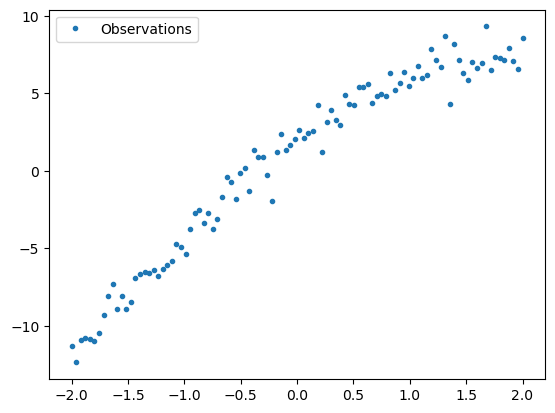

In [3]:
global y
global x
global dx

x = np.linspace(-2.0,2.0,100)
p = np.asarray([2.0,5.0,-1.0])
y = model(p,x) + np.random.randn(len(x))

indicies = np.arange(len(p))
xp = (x*np.ones((len(p),len(x)))).T
dx = np.power(xp,indicies).T

plt.plot(x,y,'.')

plt.legend(['Observations'])
plt.show()

## Initialise `HMCSampler` and assign `U` and `dU` and `qi`

`qi`: the initial guess for the parameters of interest. Walkers will be initialised close to this position in parameter space

Also set some of the optional parameters (these will use default values is not specified)

`n_samples`: the number of samples each walker will return

`n_burnin`: the number of samples that will be discarded from the start of each chain (each walker has a  separate chain). The total samples collected is n_burnin + n_samples

`lf_length`: the path length used by the leap-frog algorithm to traverse the phase-space i.e the length of the orbit segment



In [4]:
smp = HMCSampler()

smp.U = U
smp.dU = dU

smp.qi = np.asarray([1.5,4.0,0.0])

smp.n_samples = 1000
smp.n_burnin = 1000
smp.lf_length = 0.075


## Run HMC sampling by calling `run_hmc` method

Collected samples are returned into the attribute `samples`

In [5]:
smp.run_hmc()

## Plot fitted model using median value of parameter samples

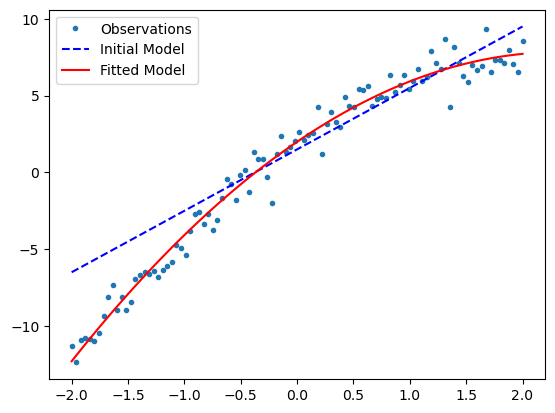

In [6]:
y0 = model(smp.qi,x)
py = model((np.median(smp.samples,axis=0)),x)

plt.plot(x,y,'.')
plt.plot(x,y0,'b--')
plt.plot(x,py,'r-')
plt.legend(['Observations','Initial Model','Fitted Model'])
plt.show()


## Plot samples of paramters of interest

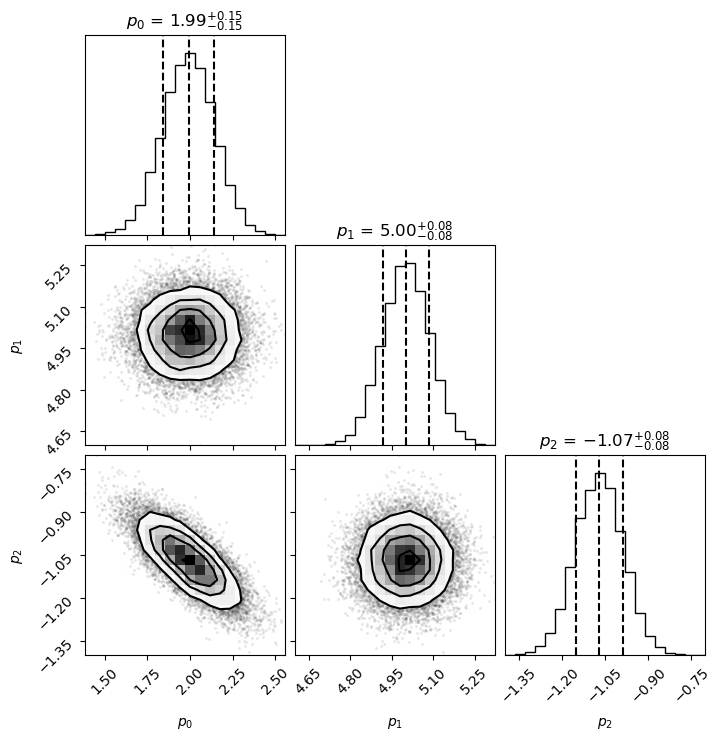

In [7]:
sample_plot = smp.plot_samples([r"$p_0$",r"$p_1$",r"$p_2$",r"$p_3$",r"$p_4$"])

## Plot first 10 orbit segments of a single walker

This can be used to check that the sampler is efficiently traversing the parameter space. If the orbit segments are too-short, increase the leap-frog path length `lf_length`.

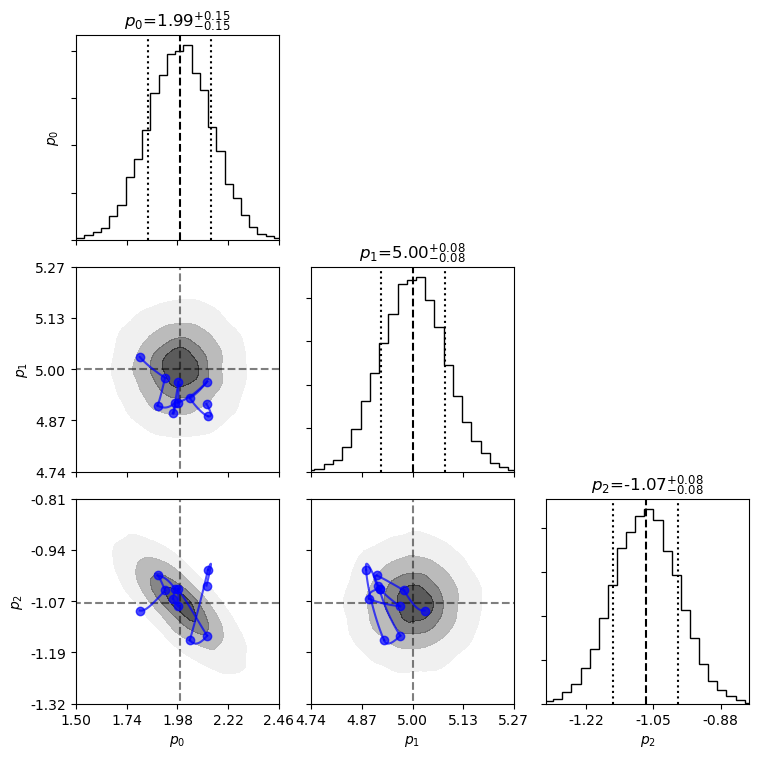

In [8]:
orbit_plot = smp.plot_orbits(10,
               [r"$p_0$",r"$p_1$",r"$p_2$",r"$p_3$",r"$p_4$"])

## Compare different path lengths

#### `lf_length` = 0.005

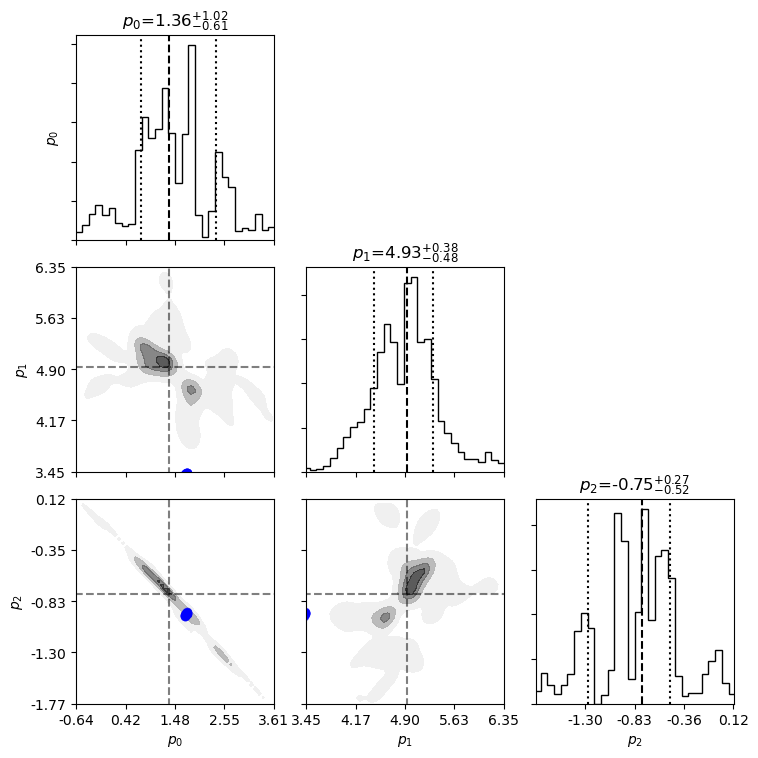

In [9]:
smp.lf_length = 0.005 #too short, probably needs a longer burn in if this is going to work
smp.run_hmc()
orbit_plot = smp.plot_orbits(10,
               [r"$p_0$",r"$p_1$",r"$p_2$",r"$p_3$",r"$p_4$"])

#### `lf_length` = 0.05

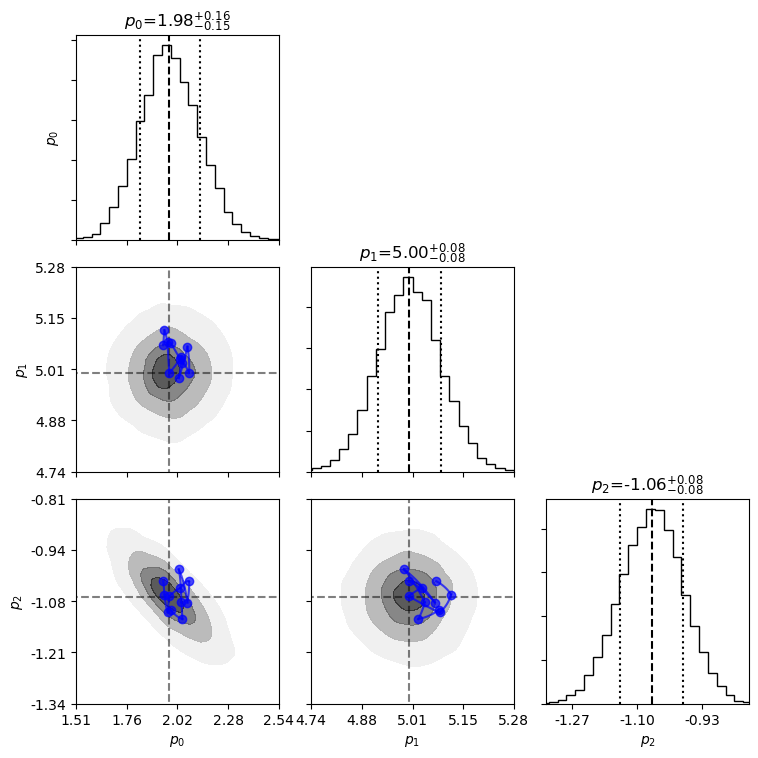

In [10]:
smp.lf_length = 0.05 #about right, could be a bit longer
smp.run_hmc()
orbit_plot = smp.plot_orbits(10,
               [r"$p_0$",r"$p_1$",r"$p_2$",r"$p_3$",r"$p_4$"])

#### `lf_length` = 0.5

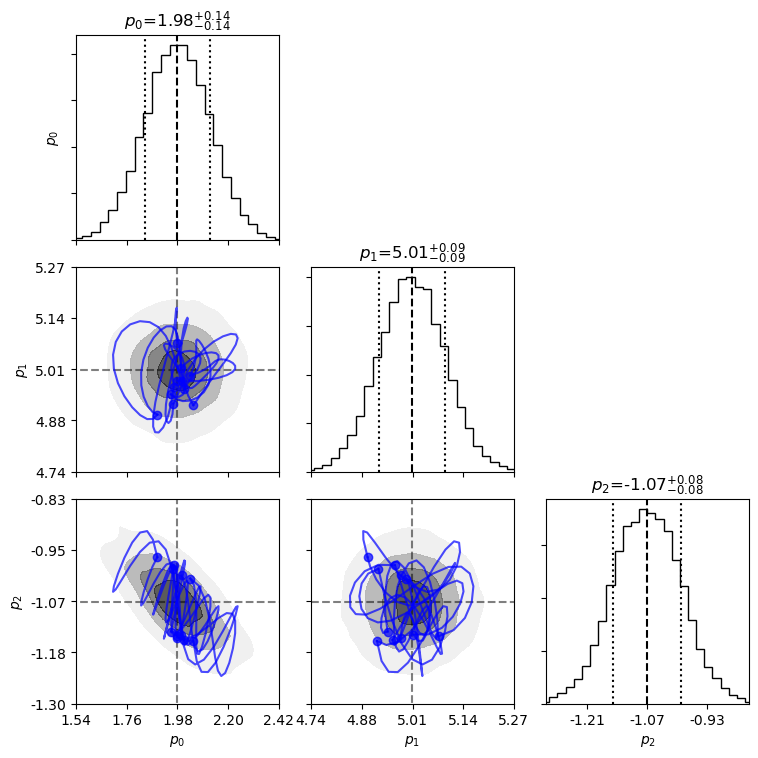

In [11]:
smp.lf_length = 0.5 #probably a bit long, but looks like it worked ok - note that it doesn't significantly change the sampled distributions
smp.run_hmc()
orbit_plot = smp.plot_orbits(10,
               [r"$p_0$",r"$p_1$",r"$p_2$",r"$p_3$",r"$p_4$"])